# Neural Networks for Almond Classification
#### Daniël van Zyl: u21446459


## Data pre-processing

#### Imports

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#### Read in data

In [3]:
data = pd.read_csv('./Almond.csv')

#### Basic Description of Data

In [4]:
data.head(1)

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA


In [5]:
#Drop Unnamed Colounm
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head(1)

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA


In [6]:
data.describe()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,1946.000000,1861.000000,1799.000000,2803.000000,2803.000000,1946.000000,2803.000000,2803.000000,1004.000000,1004.000000,2803.000000,2803.000000
mean,290.609274,171.025915,109.705378,26511.117374,743.863770,0.470466,0.955828,1.825233,1.753216,0.813114,0.724587,27696.218159
std,62.719433,29.916529,18.940597,13782.561344,230.632076,0.118673,0.039596,0.794058,0.206616,0.041312,0.047474,14237.347610
min,151.335266,88.050529,59.494278,6037.000000,311.563489,0.173748,0.718772,1.164469,1.400082,0.699897,0.454538,6355.000000
25%,245.966293,149.453659,97.091682,16211.500000,571.730009,0.384810,0.944579,1.357398,1.612490,0.784476,0.701673,17088.500000
50%,279.879883,170.168365,110.280136,23440.500000,707.487369,0.472718,0.970422,1.576412,1.705716,0.810120,0.733720,24589.000000
75%,330.508575,190.640427,121.392773,33451.000000,878.896530,0.577553,0.981484,1.965953,1.833339,0.838141,0.757551,34863.250000
max,515.352478,258.569794,181.845200,89282.000000,1864.947387,0.697293,0.992889,9.660057,2.731251,0.930563,0.845813,90642.500000


### Plots

In [7]:
def plot_histograms(data, name):
    data.hist(figsize=(8, 8), bins=30)
    plt.suptitle('Feature Distributions', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{name}.png', format='png', dpi=300)
    plt.show()

def get_num_categories(data, name):
    plt.figure(figsize=(4, 4))
    sns.countplot(x='Type', data=data, hue='Type', palette='Set1', legend=False)
    plt.title(f'Count of Each Category', fontsize=14)
    plt.xlabel('Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}.png', format='png', dpi=300)
    plt.show()

#### Distributions

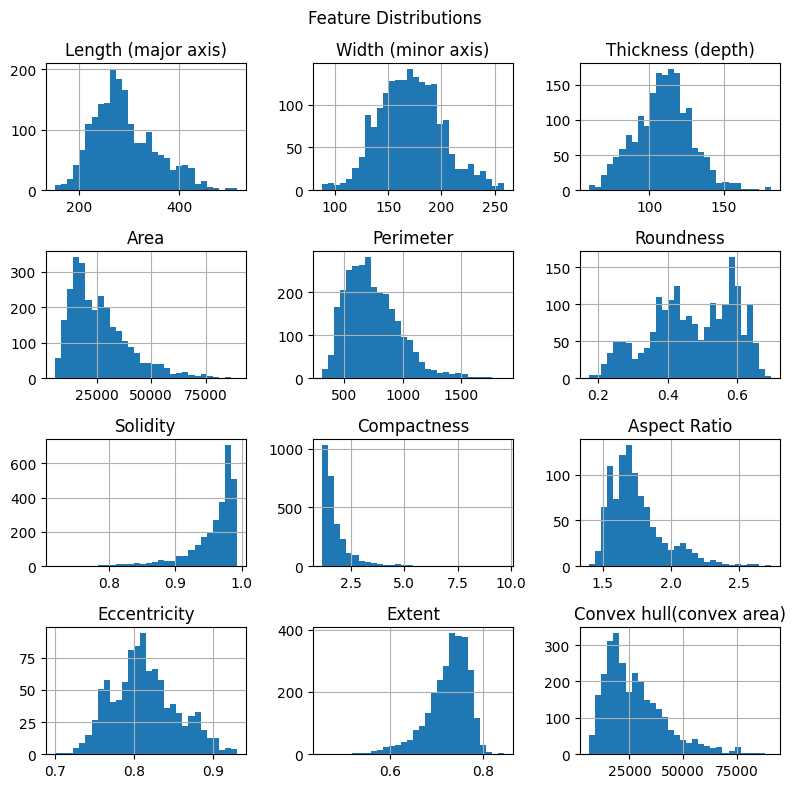

In [8]:
plot_histograms(data, "feat_dist")

#### Categories

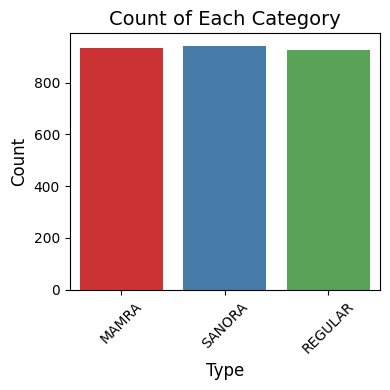

Type
SANORA     943
MAMRA      933
REGULAR    927
Name: count, dtype: int64

In [9]:
get_num_categories(data, "num_cat")
data['Type'].value_counts()

#### Handle Missing values

In [10]:
data.isnull().sum()

Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64

In [11]:
def handle_missing(data):
    imputer = KNNImputer(n_neighbors=5)
    columns_to_impute = ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)']
    
    updated_data = data.copy()
    updated_data[columns_to_impute] = imputer.fit_transform(updated_data[columns_to_impute])
    
    updated_data['Roundness'] = 4  * updated_data['Area'] / (np.pi * updated_data['Length (major axis)'] ** 2)
    updated_data['Aspect Ratio'] = updated_data['Length (major axis)'] / updated_data['Width (minor axis)']
    updated_data['Eccentricity'] = (1 - (updated_data['Width (minor axis)'] / updated_data['Length (major axis)']) ** 2)


    return updated_data

In [12]:
data_no_missing = handle_missing(data.copy())

In [13]:
data_no_missing.isnull().sum()

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

#### Handle Outliers

In [14]:
def visualise_outliers(data, name):
    features = ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 
                'Area', 'Perimeter', 'Roundness', 'Solidity', 
                'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)']
    num_features = len(features)
    cols = 4  
    rows = (num_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten() 
    
    for i, feature in enumerate(features):
        sns.boxplot(ax=axes[i], x=data[feature])
        axes[i].set_title(f'Box Plot of {feature}')
        axes[i].set_xlabel(feature)

    plt.tight_layout()
    plt.savefig(f'{name}.png', format='png', dpi=300)
    plt.show()

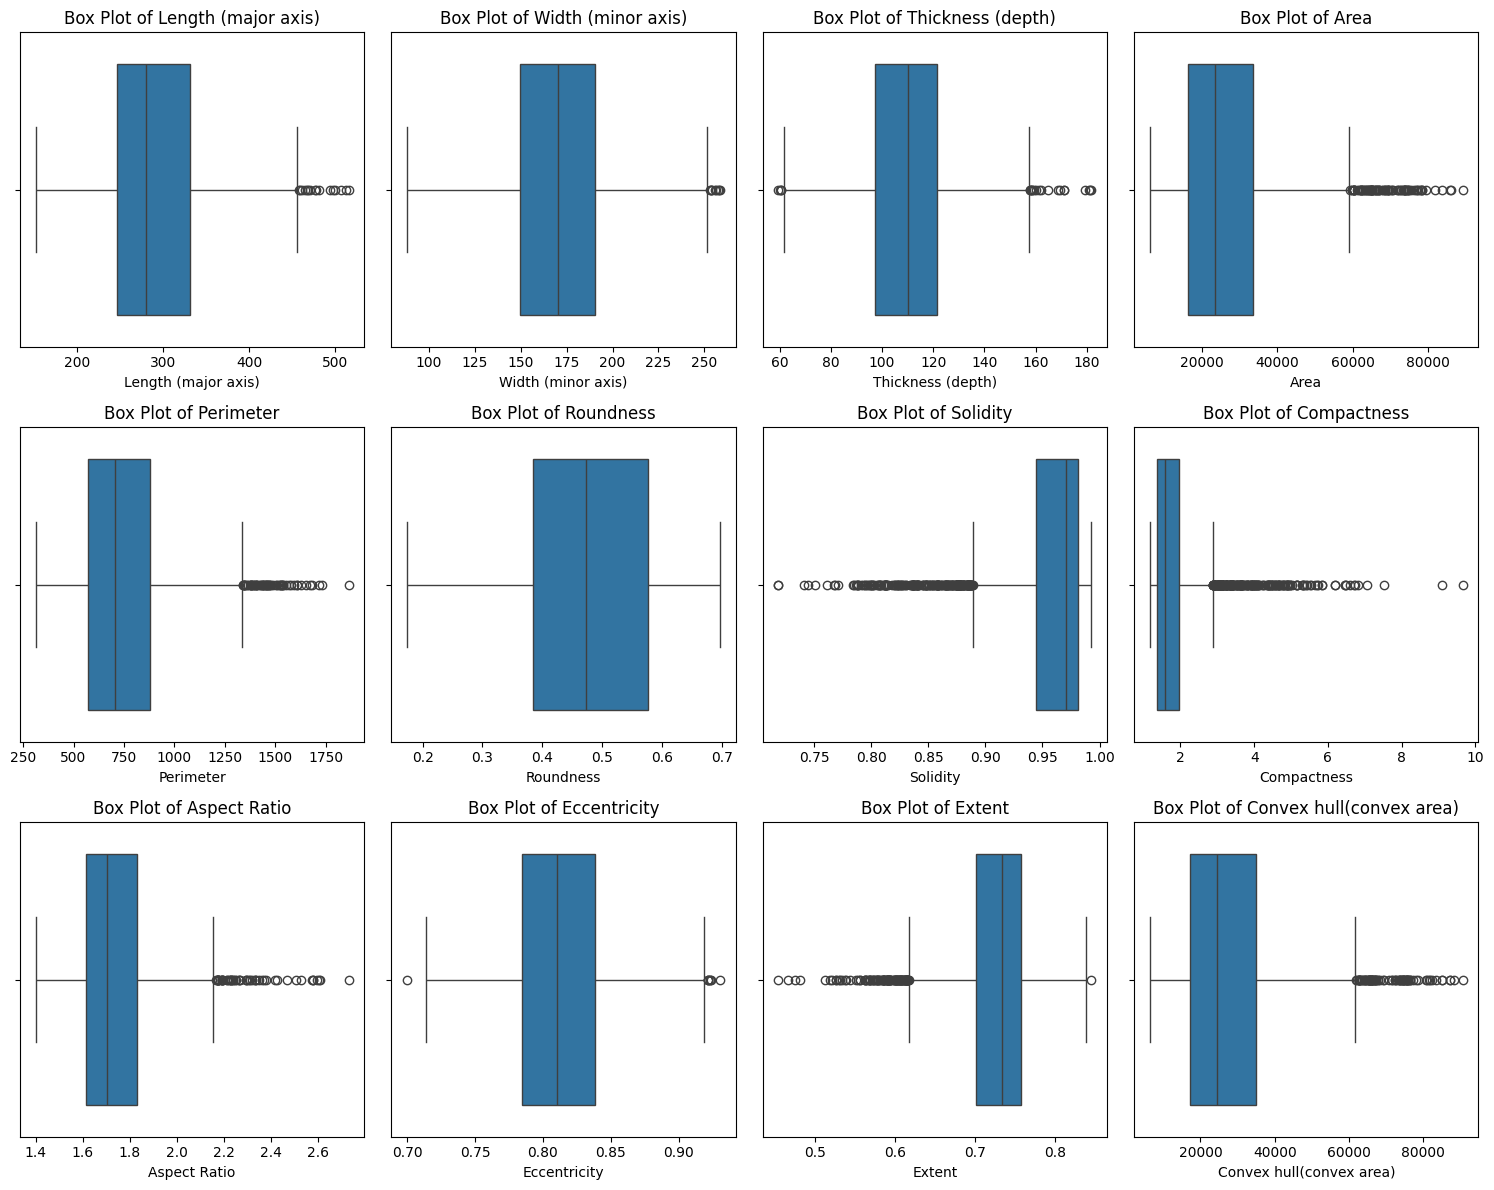

In [15]:
visualise_outliers(data, "outliers")

In [16]:
def handle_outliers(data):
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    for column in numeric_data.columns:
        skewness = numeric_data[column].skew()
        Q1 = numeric_data[column].quantile(0.25)
        Q3 = numeric_data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = (numeric_data[column] < lower_bound) | (numeric_data[column] > upper_bound)
        
        if abs(skewness) > 0.5:
            median = numeric_data[column].median()
            numeric_data.loc[outliers, column] = median
        else:
            mean = data[column].mean()
            numeric_data.loc[outliers, column] = mean

    numeric_data['Type'] = data['Type']
    return numeric_data


In [17]:
no_outliers = handle_outliers(data.copy())

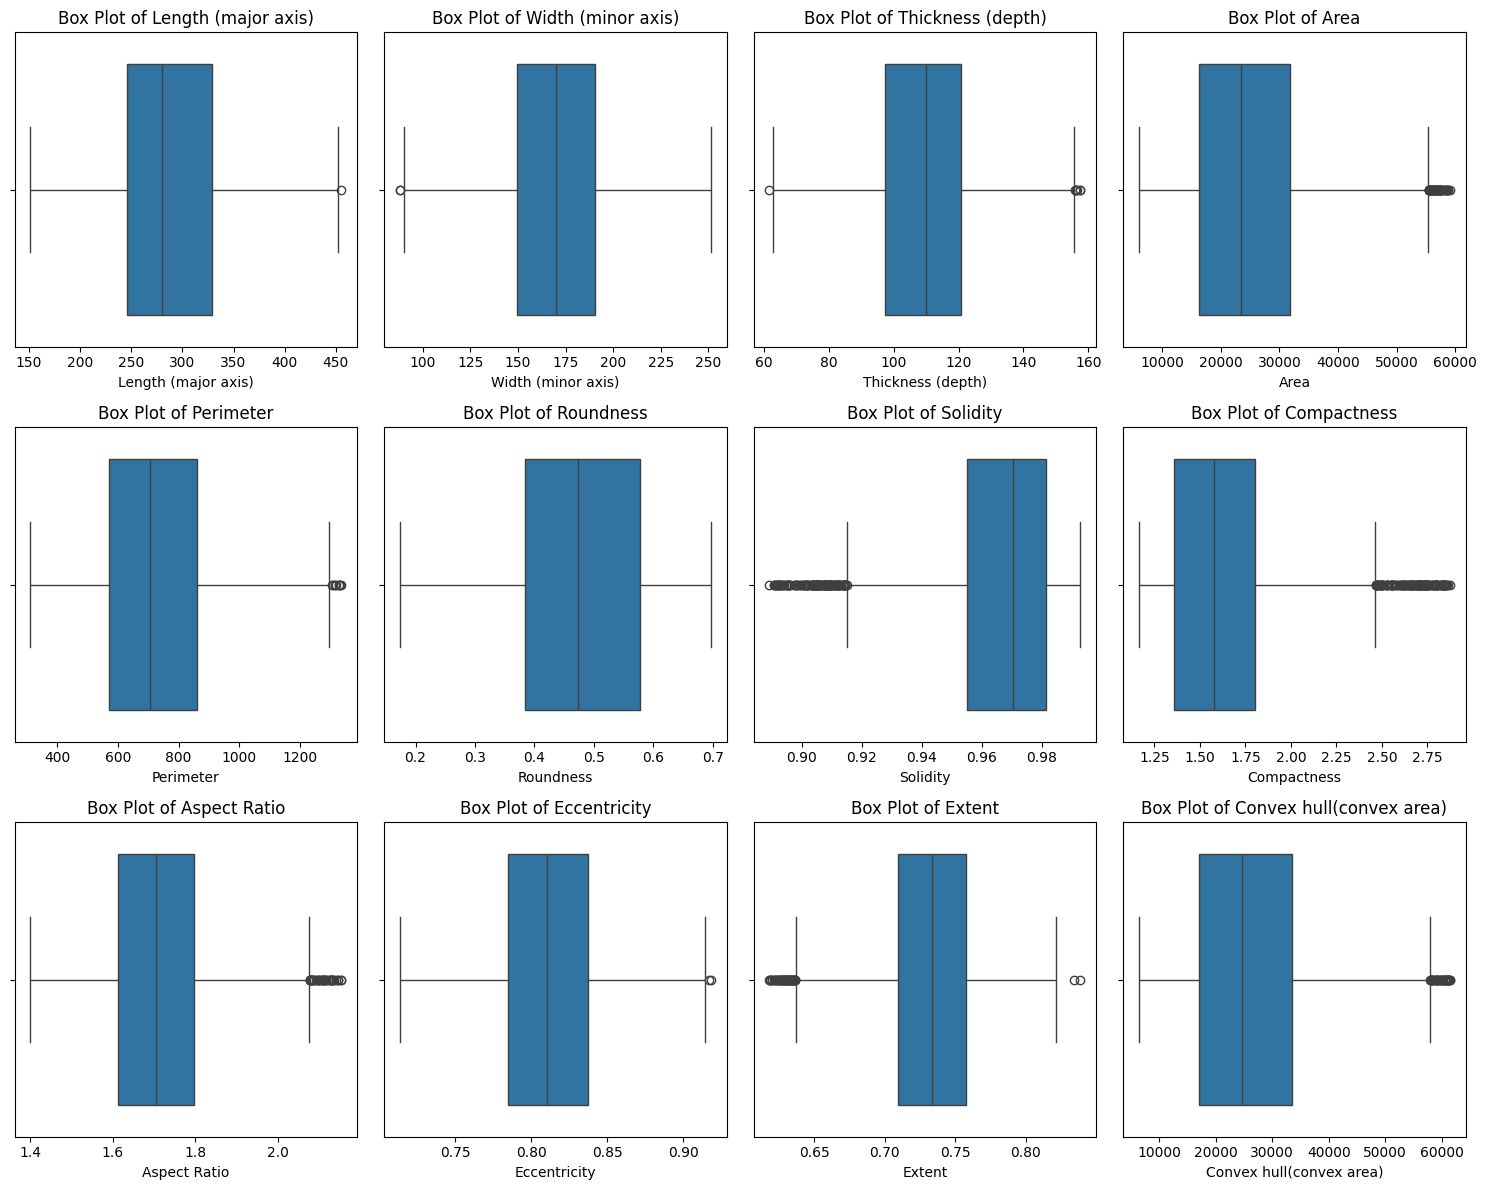

In [18]:
visualise_outliers(no_outliers, "no_outliers")

#### Clean Data

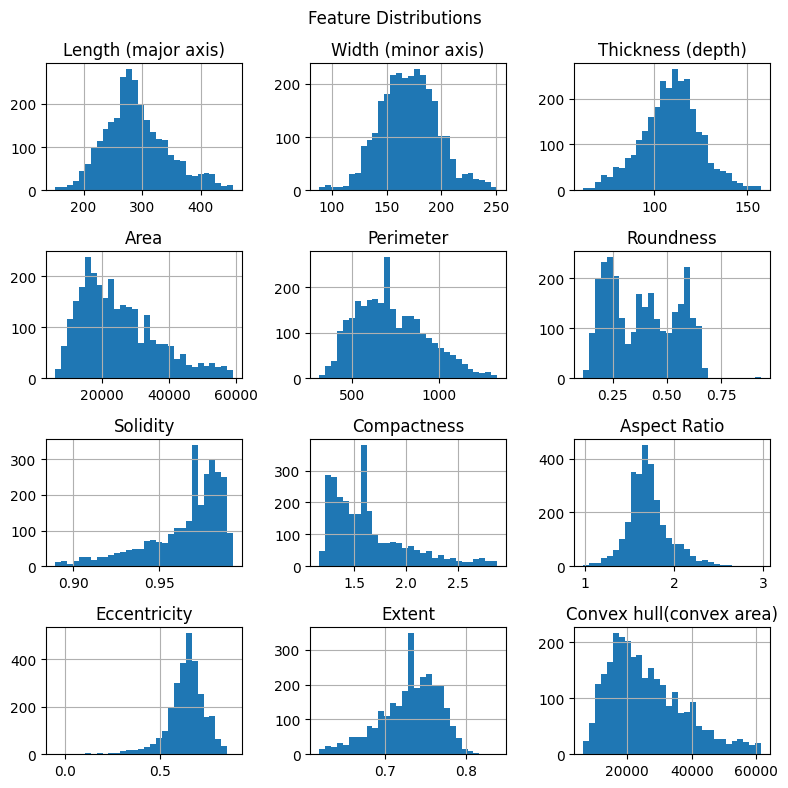

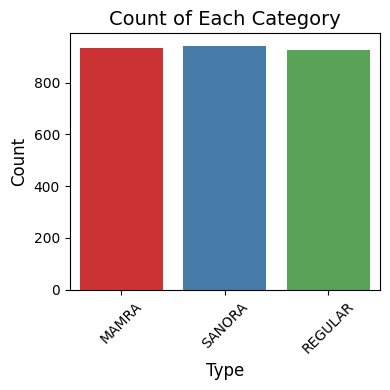

Type
SANORA     943
MAMRA      933
REGULAR    927
Name: count, dtype: int64

In [19]:
data_cleaned = handle_outliers(data.copy())
data_cleaned = handle_missing(data_cleaned.copy())

plot_histograms(data_cleaned, "cleaned_feat_dist")
get_num_categories(data_cleaned, "cleaned_num_cat")
data_cleaned['Type'].value_counts()

In [20]:
data_cleaned.isnull().sum()

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

In [21]:
data_cleaned.describe()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000
mean,290.414667,170.613525,109.051255,25092.306993,727.050674,0.387219,0.965126,1.639954,1.710296,0.638005,0.730551,26211.005708
std,54.051222,26.465483,15.821893,11418.218408,202.168168,0.156825,0.022191,0.368821,0.239341,0.103639,0.036988,11775.161268
min,151.335266,88.050529,61.589066,6037.000000,311.563489,0.112487,0.889311,1.164469,0.975345,-0.051195,0.618295,6355.000000
25%,255.005066,152.447192,99.374183,16211.500000,571.730009,0.239763,0.954939,1.357398,1.562131,0.590206,0.709183,17088.500000
50%,284.225861,170.482086,109.705378,23440.500000,707.487369,0.381137,0.970422,1.576412,1.687237,0.648725,0.733720,24589.000000
75%,320.930542,187.916994,118.846516,31870.500000,862.432063,0.536187,0.981484,1.799806,1.813709,0.696006,0.757518,33470.500000
max,455.570923,251.321655,157.605255,59072.000000,1337.276253,0.935513,0.992889,2.874083,2.981810,0.887529,0.838823,61502.500000


#### Normalise Input

In [22]:
def normalise(data):
    # scaler = MinMaxScaler(feature_range=(0, 1))
    type_column = data['Type']
    numerical_columns = data.drop(columns=['Type'])
    # data_scaled = scaler.fit_transform(numerical_columns)

    # data_scaled = pd.DataFrame(data_scaled, columns=numerical_columns.columns)
    

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(numerical_columns)
    data_scaled = pd.DataFrame(data_scaled, columns=numerical_columns.columns)
    data_scaled['Type'] = type_column
    return data_scaled

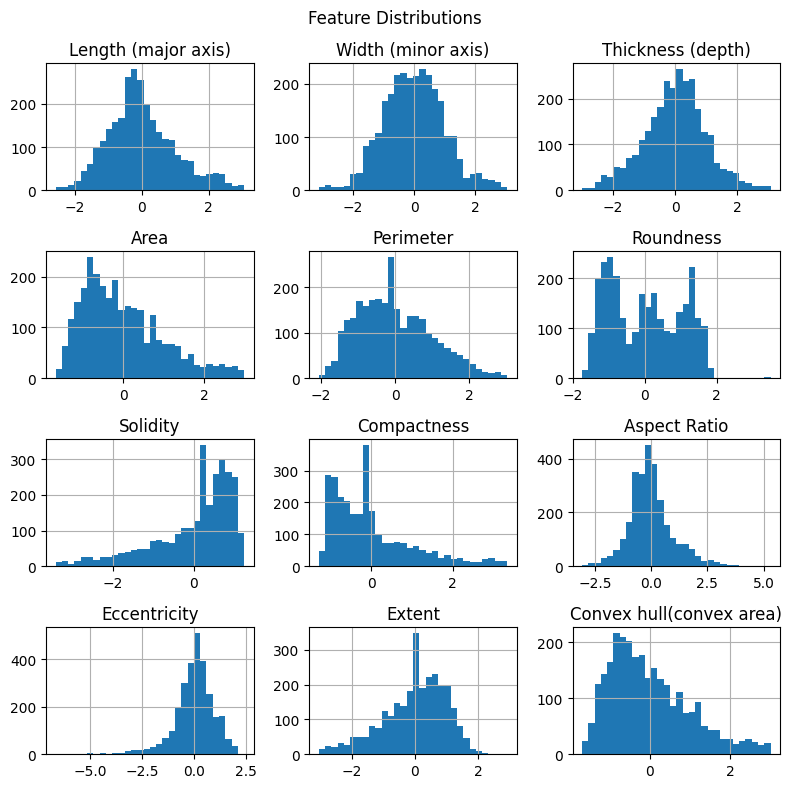

In [23]:
data_scaled = normalise(data_cleaned.copy())
data_scaled.head()
plot_histograms(data_scaled, "final_feat_dist")

#### Encode Almond Types

In [24]:
from sklearn.preprocessing import OneHotEncoder
type_encodings = {
    'REGULAR': 0,
    'MAMRA': 1,
    'SANORA': 2
}
final_data = data_scaled.copy()
final_data['Type'] = data_scaled['Type'].map(type_encodings)
# final_data = pd.get_dummies(final_data, columns=['Type'], prefix='Type')
# encoder = OneHotEncoder(sparse_output=False) 
# encoded_columns = encoder.fit_transform(data_scaled[['Type']])
# encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['Type']))
# final_data = pd.concat([data_scaled.drop('Type', axis=1), encoded_df], axis=1)

final_data.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0.026598,2.166495,1.182615,-0.216649,-0.411797,-0.313203,0.372181,-0.492709,-1.796543,-2.393243,-1.334658,-0.252569,1
1,0.661219,2.402599,1.210454,-0.179947,-0.227900,-0.710874,-0.352555,-0.103348,-1.327301,-1.482242,-2.006324,-0.182239,1
2,1.444853,2.222350,1.058551,-0.237015,-0.396312,-1.130834,0.096638,-0.412693,-0.434922,-0.247160,-1.269024,-0.260510,1
3,1.503539,2.348747,1.066280,-0.220197,-0.325644,-1.142297,0.017399,-0.268402,-0.474430,-0.291586,-1.221970,-0.240040,1
4,-0.074671,2.250019,-0.113648,-0.527699,-0.505649,-0.581592,-0.616428,-0.028634,-1.947294,-2.739519,-0.425905,-0.524078,1


### Neural Network

#### Imports & Setup

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

In [80]:
class AlmondClassifier(nn.Module):
    def __init__(self, activation=nn.ReLU(), seed=21446459, in_features=12, num_hidden_layers=2, hidden_neurons=64, out_categories=3):
        super(AlmondClassifier, self).__init__()
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.epochs = 100
        self.losses = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.predictions = []
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = any
        
        self.num_hidden = num_hidden_layers
        layers = []
        
        layers.append(nn.Linear(in_features, hidden_neurons))
        layers.append(activation)
        
        for _ in range(num_hidden_layers-1):
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(activation)
        
        layers.append(nn.Linear(hidden_neurons, out_categories))
        # layers.append(nn.Softmax(dim=1))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

    def train_classifier(self, train, train_exp, epochs=500, lr=0.001, optim="adam"):
        self.optimiser = torch.optim.Adam(self.parameters(), lr=lr)
        if(optim != "Adam"):
            self.optimiser = torch.optim.Rprop(self.parameters(), lr=lr)
        
        self.epochs = epochs
        for ep in range(self.epochs):
            outcomes = self.forward(train)
            loss = self.criterion(outcomes, train_exp)
            
            with torch.no_grad():
                predicted_classes = torch.argmax(outcomes, dim=1)
                self.losses.append(loss.detach().numpy())
                self.train_accuracy.append(np.sum(predicted_classes.numpy() == train_exp.numpy()) / predicted_classes.shape[0])
            
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

    def train_hybrid(self, train, train_exp, optimizers: list[torch.optim.Optimizer], epochs=500):
        self.epochs = epochs
        for epoch in range(epochs):
            outcomes = self.forward(train)
            loss = self.criterion(outcomes, train_exp)

            with torch.no_grad():
                predicted_classes = torch.argmax(outcomes, dim=1)
                self.losses.append(loss.detach().numpy())
                self.train_accuracy.append(np.sum(predicted_classes.numpy() == train_exp.numpy()) / predicted_classes.shape[0])
            
            for optim in optimizers:
                optim.zero_grad()

            loss.backward();

            current_weights = []
            with torch.no_grad():
                for weight in self.parameters():
                    current_weights.append(weight.data.clone())
                    
            avg_deltas = []
            for optim in optimizers:
                optim.step()
                with torch.no_grad():
                    for i, weight in enumerate(self.parameters()):
                        if i < len(avg_deltas):
                            avg_deltas[i] = np.add(np.subtract(current_weights[i], weight.data), avg_deltas[i])/len(optimizers)
                        else:
                            avg_deltas.append(np.subtract(current_weights[i], weight.data))
                            

            for i, weight in enumerate(self.parameters()):
                weight.data = np.subtract(weight.data, avg_deltas[i])

    
    def show_training_results(self, name):
        for ep in range(self.epochs):
            if ep % 5 == 0:
                print(f'Epoch: {ep} | Loss: {self.losses[ep]} | Accuracy: {self.train_accuracy[ep]}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.plot(range(self.epochs), self.losses, color='r')
        ax1.set_title('Training Error/Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Error/Loss')
        
        ax2.plot(range(self.epochs), self.train_accuracy, color='b')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')

        plt.tight_layout()
        plt.savefig(f'{name}.png', format='png', dpi=300)
        
        plt.show()
        # plt.plot(range(self.epochs), self.losses)
        # plt.ylabel("loss/error")
        # plt.xlabel("Epoch")

    def testing_nn_accuracy(self, test, test_expected):
        self.eval()
        outcomes = self.forward(test)
        loss = self.criterion(outcomes, test_expected)
        predicted_classes = torch.argmax(outcomes, dim=1)
        
        return np.sum(predicted_classes.numpy() == test_expected.numpy()) / predicted_classes.shape[0], loss.detach().numpy()
        
        

#### Train & Test Split

In [27]:
#Split data
# If bad split before pre-processing data
X = final_data.drop('Type', axis=1)
y = final_data['Type']

X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 21446459)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

### Hyperparameter Optimisation

In [222]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    # 'optimizer__lr': [0.001, 0.01, 0.1, 0.2, 0.3],
    # 'module__activation': [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.LeakyReLU(negative_slope=0.1)],
    'module__hidden_neurons': [36,48,64,128],
    'module__num_hidden_layers': [1,2,3,4],
}


def optimise_hp(model, param_grid, train_feat, train_exp):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
    return grid.fit(train_feat, train_exp)


#### Adam

Fitting 5 folds for each of 16 candidates, totalling 80 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0632       0.5033        1.0076  0.0450
      2        0.9308       0.5234        0.9445  0.0453
      3        0.8310       0.5679        0.8785  0.0463
      4        0.7863       0.5702        0.8537  0.0494
      5        0.7496       0.6013        0.8440  0.0481
      6        0.7240       0.5947        0.8293  0.0479
      7        0.7018       0.6102        0.8200  0.0471
      8        0.6826       0.6169        0.8131  0.0495
      9        0.6657       0.6147        0.8083  0.0459
     10        0.6519       0.6325        0.8091  0.0398
     11        0.6387       0.6325        0.8031  0.0454
     12        0.6272       0.6392        0.7954  0.0492
     13        0.6190       0.6414        0.7775  0.0409
     14        0.6152       0.6548        0.7534  0.0423
     15        0.6079      

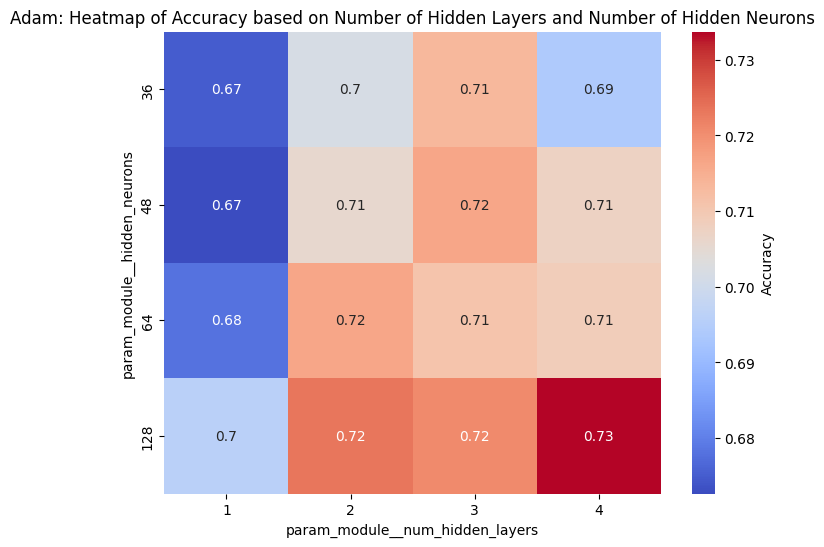

Best Training Accuracy: 0.7337297168310531
Best Params: {'module__hidden_neurons': 128, 'module__num_hidden_layers': 4}
Testing score: 0.7415329768270945


In [223]:
modelAdam = NeuralNetClassifier(
    module=AlmondClassifier,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.001,
    max_epochs=250,
)

grid_result_adam = optimise_hp(modelAdam, param_grid, X_train, y_train)

df = pd.DataFrame(grid_result_adam.cv_results_)
pivot = df.pivot(index='param_module__hidden_neurons', columns='param_module__num_hidden_layers', values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'Accuracy'})
plt.title('Adam: Heatmap of Accuracy based on Number of Hidden Layers and Number of Hidden Neurons')
plt.savefig('adam_hm.png', format='png', dpi=300)
plt.show()
print(f'Best Training Accuracy: {grid_result_adam.best_score_}')
print(f'Best Params: {grid_result_adam.best_params_}')

best_classifier_adam = grid_result_adam.best_estimator_
adam_test_score = best_classifier_adam.score(X_test, y_test)
print(f'Testing score: {adam_test_score}')



#### RProp

Fitting 5 folds for each of 16 candidates, totalling 80 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9427       0.5880        0.8764  0.0673
      2        0.7738       0.6125        0.8153  0.0635
      3        0.7281       0.6058        0.8094  0.0754
      4        0.7148       0.6013        0.8071  0.0756
      5        0.7092       0.6147        0.8031  0.0701
      6        0.7056       0.6214        0.8018  0.0693
      7        0.7056       0.6258        0.8198  0.0767
      8        0.6994       0.6258        0.8111  0.0727
      9        0.6962       0.6258        0.8086  0.0695
     10        0.6922       0.6236        0.8092  0.0728
     11        0.6915       0.6258        0.8069  0.0750
     12        0.6904       0.6258        0.8068  0.0743
     13        0.6899       0.6236        0.8072  0.0774
     14        0.6890       0.6303        0.8070  0.0739
     15        0.6928      

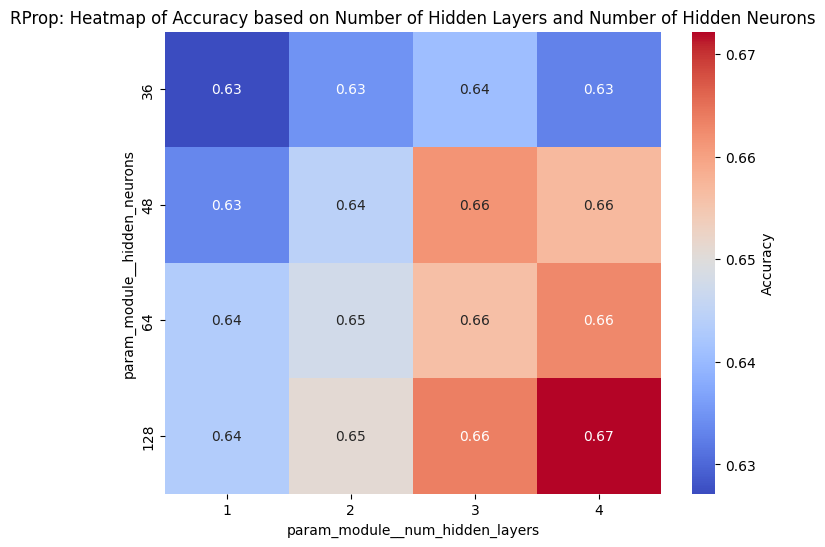

Best Training Accuracy: 0.6721812360801781
Best Params: {'module__hidden_neurons': 128, 'module__num_hidden_layers': 4}
Testing score: 0.6702317290552585


In [215]:
modelRprop= NeuralNetClassifier(
    module=AlmondClassifier,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Rprop,
    optimizer__lr=0.01,
    max_epochs=250,
)

grid_result_rprop = optimise_hp(modelRprop, param_grid, X_train, y_train)

df = pd.DataFrame(grid_result_rprop.cv_results_)
pivot_rprop = df.pivot(index='param_module__hidden_neurons', columns='param_module__num_hidden_layers', values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_rprop, annot=True, cmap="coolwarm", cbar_kws={'label': 'Accuracy'})
plt.title('RProp: Heatmap of Accuracy based on Number of Hidden Layers and Number of Hidden Neurons')
plt.savefig('rprop_hm.png', format='png', dpi=300)
plt.show()
print(f'Best Training Accuracy: {grid_result_rprop.best_score_}')
print(f'Best Params: {grid_result_rprop.best_params_}')

best_classifier_rprop = grid_result_rprop.best_estimator_
rprop_test_score = best_classifier_rprop.score(X_test, y_test)
print(f'Testing score: {rprop_test_score}')

### Statistical tests

#### T-Test For Number of Hidden Neurons

In [210]:
from scipy import stats

pivot_adam_hn = np.array(pivot_adam)
params = [36,48,64,128]
optimal_hidden_neurons = pivot_adam_hn[3]

confidence = 0.05

for i in range(0, len(pivot_adam_hn)):
    other = pivot_adam_hn[i]
    if(i != 3):
        t_stat, p_value = stats.ttest_rel(optimal_hidden_neurons, other)
        rejected = False
        if p_value < confidence:
            rejected = True
        print(f"Model: {params[i]}, T-statistic: {t_stat}, P-value: {p_value}, Significant Difference: {rejected}")

Model: 36, T-statistic: 2.679257278656054, P-value: 0.07509632986064481, Significant Difference: False
Model: 48, T-statistic: 2.673594685681682, P-value: 0.07545902551365123, Significant Difference: False
Model: 64, T-statistic: 2.6561567541515707, P-value: 0.07658964602846734, Significant Difference: False


#### T-Test for Number of Hidden Layers

In [213]:
pivot_adam_af = np.array(pivot_adam)
params = [1,2,3,4]

optimal_activation_function = []
for i in range(len(pivot_adam_af)):
    optimal_activation_function.append(pivot_adam_af[i][2])
    
optimal_activation_function = np.array(optimal_activation_function)

confidence = 0.05

for i in range(0, len(pivot_adam_af)):
    other = []
    for j in range(len(pivot_adam_af)):
        other.append(pivot_adam_af[i][j])
    other = np.array(other)
    if(i != 3):
        t_stat, p_value = stats.ttest_rel(optimal_activation_function, other)
        rejected = False
        if p_value < confidence:
            rejected = True
        print(f"Model: {params[i]}, T-statistic: {t_stat}, P-value: {p_value}, Significant Difference: {rejected}")

Model: 1, T-statistic: 1.7221874852765264, P-value: 0.18351312022128793, Significant Difference: False
Model: 2, T-statistic: 1.3671580716337874, P-value: 0.26500479367144175, Significant Difference: False
Model: 3, T-statistic: 0.9160735582408258, P-value: 0.4271807858452379, Significant Difference: False


#### T-Test for combination

In [1]:
results_df = pd.DataFrame(grid_result_adam.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")


model_scores = results_df.filter(regex=r"split\d*_test_score")
best_scores = model_scores.iloc[0].values

confidence = 0.05

for i in range (1, len(model_scores)):
    other = model_scores.iloc[i].values
    t_stat, p_value = stats.ttest_rel(best_scores, other)
    rejected = False
    if p_value < confidence:
        rejected = True
    print(f"Model: {i}, T-statistic: {t_stat}, P-value: {p_value}, Significant Difference: {rejected}")


NameError: name 'pd' is not defined

### Algorithm Comparrisons

#### Adam

In [134]:
import time
import csv
adam_results = []

Epoch: 0 | Loss: 1.0982747077941895 | Accuracy: 0.33630686886708294
Epoch: 5 | Loss: 1.0328327417373657 | Accuracy: 0.463871543264942
Epoch: 10 | Loss: 0.8627187609672546 | Accuracy: 0.5825156110615521
Epoch: 15 | Loss: 0.7934618592262268 | Accuracy: 0.6409455842997324
Epoch: 20 | Loss: 0.7490546703338623 | Accuracy: 0.6574487065120428
Epoch: 25 | Loss: 0.6981489658355713 | Accuracy: 0.6895628902765388
Epoch: 30 | Loss: 0.6461866497993469 | Accuracy: 0.7185548617305977
Epoch: 35 | Loss: 0.5915857553482056 | Accuracy: 0.7471008028545941
Epoch: 40 | Loss: 0.5427871942520142 | Accuracy: 0.77921498661909
Epoch: 45 | Loss: 0.4965094029903412 | Accuracy: 0.7948260481712757
Epoch: 50 | Loss: 0.4591516852378845 | Accuracy: 0.8113291703835861
Epoch: 55 | Loss: 0.4163540005683899 | Accuracy: 0.8354148082069581
Epoch: 60 | Loss: 0.38183560967445374 | Accuracy: 0.8461195361284567
Epoch: 65 | Loss: 0.3420047461986542 | Accuracy: 0.8617305976806423
Epoch: 70 | Loss: 0.305335134267807 | Accuracy: 0.8

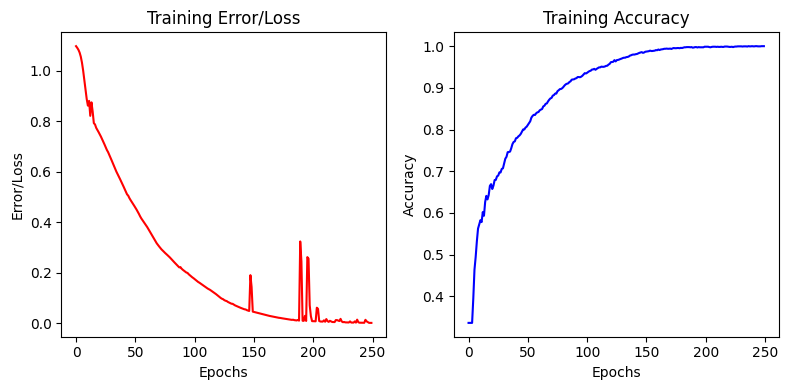

NN Testing Accuracy: 0.7290552584670231
NN Testing Loss: 16.5380859375


In [154]:
seed = int(time.time())
classifier_adam = AlmondClassifier(activation=nn.ReLU(),seed=seed, num_hidden_layers=4, hidden_neurons=128)
classifier_adam.train_classifier(X_train, y_train, epochs=250, lr=0.001)
classifier_adam.show_training_results("adam_training")

accuracy, loss = classifier_adam.testing_nn_accuracy(X_test, y_test)
adam_results.append({"seed":seed, "accuracy":accuracy, "loss": loss.item()})
print(f'NN Testing Accuracy: {accuracy}')
print(f'NN Testing Loss: {loss.item()}')

In [155]:
with open('adam_final_results.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['seed', 'accuracy', 'loss'])
    writer.writeheader()
    writer.writerows(adam_results)

#### RProp

In [221]:
rprop_results = []

Epoch: 0 | Loss: 1.0973702669143677 | Accuracy: 0.3438893844781445
Epoch: 5 | Loss: 1.1429494619369507 | Accuracy: 0.5504014272970562
Epoch: 10 | Loss: 0.8599360585212708 | Accuracy: 0.5927743086529884
Epoch: 15 | Loss: 0.7445310354232788 | Accuracy: 0.6672613737734165
Epoch: 20 | Loss: 0.6801443696022034 | Accuracy: 0.7024977698483497
Epoch: 25 | Loss: 0.6169882416725159 | Accuracy: 0.7444246208742195
Epoch: 30 | Loss: 0.5422113537788391 | Accuracy: 0.776092774308653
Epoch: 35 | Loss: 0.4825747609138489 | Accuracy: 0.8090990187332738
Epoch: 40 | Loss: 0.43199825286865234 | Accuracy: 0.8287243532560215
Epoch: 45 | Loss: 0.3862622380256653 | Accuracy: 0.8479036574487065
Epoch: 50 | Loss: 0.3411973714828491 | Accuracy: 0.8733273862622658
Epoch: 55 | Loss: 0.3006722629070282 | Accuracy: 0.8884924174843889
Epoch: 60 | Loss: 0.2657281160354614 | Accuracy: 0.9058876003568243
Epoch: 65 | Loss: 0.22703707218170166 | Accuracy: 0.9250669045495094
Epoch: 70 | Loss: 0.19162507355213165 | Accuracy:

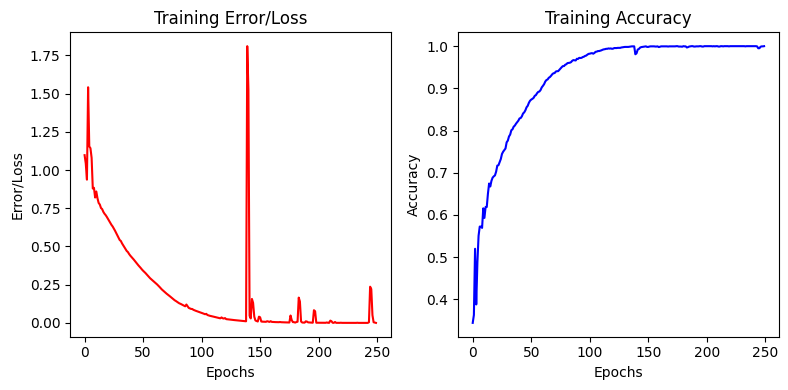

NN Testing Accuracy: 0.7272727272727273
NN Testing Loss: 23.248933792114258


In [241]:
r_seed = int(time.time())
classifier_rprop = AlmondClassifier(activation=nn.ReLU(),seed=r_seed, num_hidden_layers=4, hidden_neurons=128)
classifier_rprop.train_classifier(X_train, y_train, epochs=250, lr=0.01, optim="rprop")
classifier_rprop.show_training_results("rprop_training")

accuracy, loss = classifier_rprop.testing_nn_accuracy(X_test, y_test)
rprop_results.append({"seed":r_seed, "accuracy":accuracy, "loss": loss.item()})
print(f'NN Testing Accuracy: {accuracy}')
print(f'NN Testing Loss: {loss.item()}')

In [242]:
with open('rprop_final_results.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['seed', 'accuracy', 'loss'])
    writer.writeheader()
    writer.writerows(rprop_results)

### Hybrid Learning

In [243]:
hybrid_results = []

Epoch: 0 | Loss: 1.0995194911956787 | Accuracy: 0.3438893844781445
Epoch: 5 | Loss: 0.9439550042152405 | Accuracy: 0.5254237288135594
Epoch: 10 | Loss: 0.8573265075683594 | Accuracy: 0.6173059768064229
Epoch: 15 | Loss: 0.7280969023704529 | Accuracy: 0.6842105263157895
Epoch: 20 | Loss: 0.6540681719779968 | Accuracy: 0.7261373773416593
Epoch: 25 | Loss: 0.5970876216888428 | Accuracy: 0.7475468331846565
Epoch: 30 | Loss: 0.5356314778327942 | Accuracy: 0.776092774308653
Epoch: 35 | Loss: 0.47814396023750305 | Accuracy: 0.8095450490633364
Epoch: 40 | Loss: 0.4179737865924835 | Accuracy: 0.8336306868867083
Epoch: 45 | Loss: 0.3616003692150116 | Accuracy: 0.851471900089206
Epoch: 50 | Loss: 0.312407523393631 | Accuracy: 0.8773416592328278
Epoch: 55 | Loss: 0.2689155042171478 | Accuracy: 0.8974130240856378
Epoch: 60 | Loss: 0.23573598265647888 | Accuracy: 0.9112399643175736
Epoch: 65 | Loss: 0.20269803702831268 | Accuracy: 0.9246208742194469
Epoch: 70 | Loss: 0.17276310920715332 | Accuracy: 

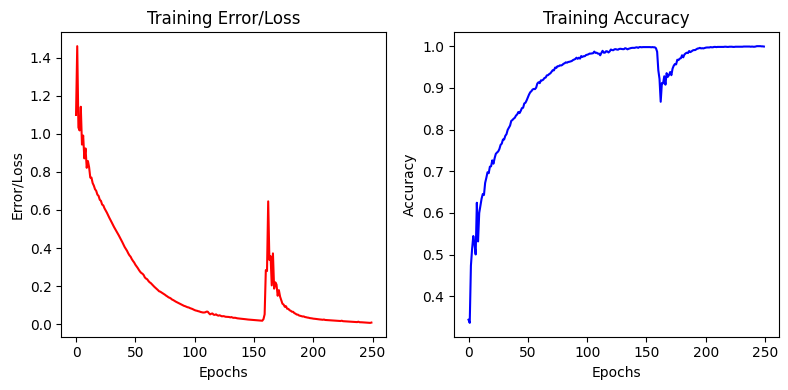

NN Testing Accuracy: 0.7450980392156863


In [263]:
#Train
h_seed = int(time.time())
classifier_hybrid = AlmondClassifier(activation=nn.ReLU(),seed=h_seed, num_hidden_layers=4, hidden_neurons=128)
optimizers = [
    torch.optim.Adam(classifier_hybrid.parameters(), lr=0.001),
    torch.optim.Rprop(classifier_hybrid.parameters(), lr=0.01)
]
classifier_hybrid.train_hybrid(X_train, y_train, optimizers=optimizers, epochs=250)
classifier_hybrid.show_training_results("hybrid_training")

#Test
accuracy, loss = classifier_hybrid.testing_nn_accuracy(X_test, y_test)
hybrid_results.append({"seed":h_seed, "accuracy":accuracy, "loss": loss.item()})
print(f'NN Testing Accuracy: {accuracy}')

In [264]:
with open('hybrid_final_results.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['seed', 'accuracy', 'loss'])
    writer.writeheader()
    writer.writerows(hybrid_results)

### Results

In [265]:
def get_best(data):
    return data["accuracy"].max(), data["loss"].min()

def get_mean(data, key):
    return data[key].mean()

def get_std(data, key):
    return data[key].std()

In [266]:
adam_results = pd.read_csv('./adam_final_results.csv')
rprop_results = pd.read_csv('./rprop_final_results.csv')
hybrid_results = pd.read_csv('./hybrid_final_results.csv')

In [267]:
adam_best_acc, adam_best_loss = get_best(adam_results)
adam_mean_acc = get_mean(adam_results, "accuracy")
adam_std_acc = get_std(adam_results, "accuracy")
adam_mean_loss = get_mean(adam_results, "loss")
adam_std_loss = get_std(adam_results, "loss")

print("============ ADAM ============")
print(f'Best Accuracy: {adam_best_acc}, Best Loss: {adam_best_loss}')
print(f'Mean Accuracy: {adam_mean_acc}, Mean Loss: {adam_mean_loss}')
print(f'Std Accuracy: {adam_std_acc}, Std Loss: {adam_std_loss}')
print()

rprop_best_acc, rprop_best_loss = get_best(rprop_results)
rprop_mean_acc = get_mean(rprop_results, "accuracy")
rprop_std_acc = get_std(rprop_results, "accuracy")
rprop_mean_loss = get_mean(rprop_results, "loss")
rprop_std_loss = get_std(rprop_results, "loss")

print("============ RProp ============")
print(f'Best Accuracy: {rprop_best_acc}, Best Loss: {rprop_best_loss}')
print(f'Mean Accuracy: {rprop_mean_acc}, Mean Loss: {rprop_mean_loss}')
print(f'Std Accuracy: {rprop_std_acc}, Std Loss: {rprop_std_loss}')
print()

hybrid_best_acc, hybrid_best_loss = get_best(hybrid_results)
hybrid_mean_acc = get_mean(hybrid_results, "accuracy")
hybrid_std_acc = get_std(hybrid_results, "accuracy")
hybrid_mean_loss = get_mean(hybrid_results, "loss")
hybrid_std_loss = get_std(hybrid_results, "loss")

print("============ Hybrid ============")
print(f'Best Accuracy: {hybrid_best_acc}, Best Loss: {hybrid_best_loss}')
print(f'Mean Accuracy: {hybrid_mean_acc}, Mean Loss: {hybrid_mean_loss}')
print(f'Std Accuracy: {hybrid_std_acc}, Std Loss: {hybrid_std_loss}')
print()

============ ADAM ============
Best Accuracy: 0.7557932263814616, Best Loss: 8.34631061553955
Mean Accuracy: 0.723440285204991, Mean Loss: 15.4532940864563
Std Accuracy: 0.015061847327664009, Std Loss: 5.260842720363828

============ RProp ============
Best Accuracy: 0.7450980392156863, Best Loss: 6.449560165405273
Mean Accuracy: 0.7222816399286988, Mean Loss: 17.053408765792845
Std Accuracy: 0.009478253944189477, Std Loss: 5.85980335854654

============ Hybrid ============
Best Accuracy: 0.7593582887700535, Best Loss: 2.148026943206787
Mean Accuracy: 0.7307486631016044, Mean Loss: 5.756896185874939
Std Accuracy: 0.02031143053811267, Std Loss: 6.986199286543982



#### T-Tests for models

In [270]:
def t_test(model_1, model_2, confidence):
    t_stat, p_value = stats.ttest_rel(model_1, model_2)
    rejected = False
    if p_value < confidence:
        rejected = True

    return t_stat, p_value, rejected

In [273]:
adam_acc = adam_results["accuracy"]
rprop_acc = rprop_results["accuracy"]
hybrid_acc = hybrid_results["accuracy"]

adam_loss = adam_results["loss"]
rprop_loss = rprop_results["loss"]
hybrid_loss = hybrid_results["loss"]

#### Accuracy T-Tests

In [276]:
acc_t, acc_p, acc_rej = [], [], []

t, p, rej = t_test(adam_acc, rprop_acc, 0.05)
acc_t.append(t)
acc_p.append(p)
acc_rej.append(rej)

t, p, rej = t_test(rprop_acc, adam_acc, 0.05)
acc_t.append(t)
acc_p.append(p)
acc_rej.append(rej)

t, p, rej = t_test(hybrid_acc, adam_acc, 0.05)
acc_t.append(t)
acc_p.append(p)
acc_rej.append(rej)

t, p, rej = t_test(hybrid_acc, rprop_acc, 0.05)
acc_t.append(t)
acc_p.append(p)
acc_rej.append(rej)

In [278]:
loss_t, loss_p, loss_rej = [], [], []

t, p, rej = t_test(adam_loss, rprop_loss, 0.05)
loss_t.append(t)
loss_p.append(p)
loss_rej.append(rej)

t, p, rej = t_test(rprop_loss, adam_loss, 0.05)
loss_t.append(t)
loss_p.append(p)
loss_rej.append(rej)

t, p, rej = t_test(hybrid_loss, adam_loss, 0.05)
loss_t.append(t)
loss_p.append(p)
loss_rej.append(rej)

t, p, rej = t_test(hybrid_loss, rprop_loss, 0.05)
loss_t.append(t)
loss_p.append(p)
loss_rej.append(rej)

In [281]:
print("T-Tests for difference in accuracy")
for i in range(len(acc_t)):
    print(f'T-statistic: {acc_t[i]}, P-value: {acc_p[i]}, Rejected: {acc_rej[i]}')

print()
print("T-Tests for difference in loss")
for i in range(len(loss_t)):
    print(f'T-statistic: {loss_t[i]}, P-value: {loss_p[i]}, Rejected: {loss_rej[i]}')

T-Tests for difference in accuracy
T-statistic: 0.2498177213470858, P-value: 0.8054093920180561, Rejected: False
T-statistic: -0.2498177213470858, P-value: 0.8054093920180561, Rejected: False
T-statistic: 1.2225554264692724, P-value: 0.2364470771563315, Rejected: False
T-statistic: 1.7060331462651845, P-value: 0.10429560058692104, Rejected: False

T-Tests for difference in loss
T-statistic: -0.8698189932439516, P-value: 0.39525556661220607, Rejected: False
T-statistic: 0.8698189932439516, P-value: 0.39525556661220607, Rejected: False
T-statistic: -4.699742295611971, P-value: 0.00015601285993874225, Rejected: True
T-statistic: -5.286079266936418, P-value: 4.213207709181454e-05, Rejected: True
